In [8]:
# %% [markdown]
# # Neural preconditioner (2 → 4) for Helmholtz GMRES
# 
# Goal:
# - Use many sample solutions at ω=2 and ω=4, with the same right-hand sides.
# - Train a neural operator T_θ that maps u(ω=2) → u(ω=4).
# - Make T_θ as PDE-consistent as possible at ω=4:
#       A_4 T_θ(u_2) ≈ b   (small residual)
# - This T_θ can then act as an approximate inverse / preconditioner for A_4.
#
# In this notebook we:
# 1. Build a dataset of (u_2, u_4) pairs.
# 2. Build an extended dataset that also stores b_4 = A_4 u_4.
# 3. Train an FNO-based neural operator with a combined loss:
#       L = ||u_pred - u_4||^2 + λ * ||A_4 u_pred - b_4||^2
# 4. Check how PDE-consistent the learned operator is.


In [1]:
import sys
from pathlib import Path

import numpy as np
import torch

# -------------------------------------------------------------------
# Detect the project root (directory containing src/)
# -------------------------------------------------------------------
CWD = Path.cwd()

PROJECT_ROOT = None
for parent in [CWD, *CWD.parents]:
    if (parent / "src" / "__init__.py").exists():
        PROJECT_ROOT = parent
        break

if PROJECT_ROOT is None:
    raise RuntimeError(
        f"Could not find project root containing src/. Started search from: {CWD}"
    )

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT =", PROJECT_ROOT)



PROJECT_ROOT = c:\Users\31624\Documents\MIT\Programming\FreqTransfer


In [2]:
# %%
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt

from src.config import GridSpec, PMLConfig, FDConfig, SolverOptions, omega_to_k
from src.data import (
    get_freq_dataset,
    ScaleWrapper,
    StdNormWrapper,
    CoordWrapper,
    OmegaChannelWrapper,
)
from src.ml import SimpleFNO, compute_input_stats
from src.operators import assemble_operator
from src.solvers import gmres_solve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Grid & PML configuration
grid = GridSpec(
    dims=2,
    shape=(48, 48),
    lengths=(1.0, 1.0),
)
pml_cfg = PMLConfig(thickness=16, m=2, sigma_max=10.0)
fd_cfg = FDConfig()

# Frequencies for *preconditioner step*
omega_src = 2.0
omega_tgt = 4.0

k_tgt = omega_to_k(omega_tgt)

print(f"Grid: {grid.shape}, ω_src={omega_src}, ω_tgt={omega_tgt}")


Using device: cpu
Grid: (48, 48), ω_src=2.0, ω_tgt=4.0


In [3]:
# %% [markdown]
# ## Build raw dataset for ω=2 → ω=4
# Each sample: (u_2, u_4) with shared RHS.

# %%
N_samples = 512  # adjust if needed for speed

raw_ds = get_freq_dataset(
    grid=grid,
    pml=pml_cfg,
    omega_src=omega_src,
    omega_tgt=omega_tgt,
    N_samples=N_samples,
)

print("Raw dataset length:", len(raw_ds))
u2_0, u4_0 = raw_ds[0]
print("u_2 shape:", u2_0.shape)  # (2, H, W)
print("u_4 shape:", u4_0.shape)  # (2, H, W)


[get_freq_dataset] Loading cached dataset from: C:\Users\31624\Documents\MIT\Programming\FreqTransfer\data\freq_transfer_cached\wsrc2p000_wtgt4p000_N512_grid48x48_pmlT16_m2_sig10p00
  Loaded N=512 samples, ω_src=2.0, ω_tgt=4.0
Raw dataset length: 512
u_2 shape: torch.Size([2, 48, 48])
u_4 shape: torch.Size([2, 48, 48])


In [4]:
# %% [markdown]
# ## Apply scaling, normalisation, and add coordinates & frequency channels

# %%
# 1) Scale amplitudes up to O(1) (Helmholtz magnitudes are tiny)
scale_factor = 1e4
scaled_ds = ScaleWrapper(raw_ds, factor=scale_factor)

# 2) Standardise u_2 channels using mean/std over a subset
mean, std = compute_input_stats(scaled_ds, max_samples=200)
norm_ds = StdNormWrapper(scaled_ds, mean=mean, std=std)

# 3) Add coordinates (x, y)
coord_ds = CoordWrapper(norm_ds, grid=grid, normalise=True)

# 4) Add ω_src, ω_tgt channels
freq_ds = OmegaChannelWrapper(coord_ds, omega_src=omega_src, omega_tgt=omega_tgt)

# Sanity check
x0, y0 = freq_ds[0]
print("Final input shape (u2+coords+freq):", x0.shape)  # e.g. (6, H, W)
print("Final target shape (u4):           ", y0.shape)  # (2, H, W)


Final input shape (u2+coords+freq): torch.Size([6, 48, 48])
Final target shape (u4):            torch.Size([2, 48, 48])


In [5]:
# %% [markdown]
# ## Add PDE information: compute b_4 = A_4 u_4 for each sample
# We will store b_4 so we can compute Helmholtz residuals A_4 u_pred - b_4 in the loss.

# %%
# Assemble A_4 once
A_4 = assemble_operator(
    grid=grid,
    k=k_tgt,
    kind="helmholtz",
    fd=fd_cfg,
    pml=pml_cfg,
)

H, W = grid.shape
N = H * W

# Precompute b_4 for each sample in freq_ds
b4_list = []

for idx in range(len(freq_ds)):
    _, u4 = freq_ds[idx]              # u4: (2, H, W)
    u4_np = u4.numpy()
    u4_complex = (u4_np[0] + 1j * u4_np[1]).reshape(-1)  # flatten to (N,)
    b4 = A_4 @ u4_complex             # complex RHS
    b4_list.append(b4)

b4_array = np.stack(b4_list, axis=0)  # shape (N_samples, N)
print("b4_array shape:", b4_array.shape)


b4_array shape: (512, 2304)


In [7]:
# %% [markdown]
# ## Custom dataset: (input_features, target_u4, target_b4)

# %%
class HelmholtzTransferDataset(Dataset):
    def __init__(self, base_ds, b4_array):
        assert len(base_ds) == b4_array.shape[0]
        self.base_ds = base_ds
        self.b4 = b4_array  # numpy array (N_samples, N)

    def __len__(self):
        return len(self.base_ds)

    def __getitem__(self, idx):
        x, y = self.base_ds[idx]  # x: (C_in, H, W), y: (2, H, W)
        b4 = self.b4[idx]         # complex vector (N,)
        # return tensor versions
        b4_r = torch.from_numpy(np.real(b4)).float()
        b4_i = torch.from_numpy(np.imag(b4)).float()
        b4_cat = torch.stack([b4_r, b4_i], dim=0)  # (2, N)
        return x, y, b4_cat

transfer_ds = HelmholtzTransferDataset(freq_ds, b4_array)
print("Transfer dataset length:", len(transfer_ds))

x_s, y_s, b4_s = transfer_ds[0]
print("x_s shape (input): ", x_s.shape)
print("y_s shape (u4):    ", y_s.shape)
print("b4_s shape (b4):   ", b4_s.shape)  # (2, N)


Transfer dataset length: 512
x_s shape (input):  torch.Size([6, 48, 48])
y_s shape (u4):     torch.Size([2, 48, 48])
b4_s shape (b4):    torch.Size([2, 2304])


In [8]:
# %% [markdown]
# ## Train/validation split

# %%
val_split = 0.2
n_val = int(val_split * len(transfer_ds))
n_train = len(transfer_ds) - n_val

train_ds, val_ds = random_split(
    transfer_ds,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(0),
)

batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

print(f"Train samples: {n_train}, Val samples: {n_val}")


Train samples: 410, Val samples: 102


In [9]:
# %% [markdown]
# ## FNO-based transfer operator T_θ: u_2 → u_4

# %%
in_channels  = x_s.shape[0]   # e.g. 6
out_channels = y_s.shape[0]   # should be 2 (Re, Im)

precond_net = SimpleFNO(
    in_ch=in_channels,
    out_ch=out_channels,
    width=48,            # can increase later
    modes=(12, 12),      # can increase later
    layers=4,            # can deepen later
    use_global_skip=False,
).to(device)

print("Number of parameters:",
      sum(p.numel() for p in precond_net.parameters()))


Number of parameters: 2664050


In [ ]:
# %% [markdown]
# ## Training loop with PDE residual loss

# %%
optimizer = torch.optim.Adam(precond_net.parameters(), lr=1e-3)
epochs = 40
lambda_pde = 1e-2   # weight for PDE residual term, tune this

H, W = grid.shape
N = H * W

def complex_from_2ch(field):
    # field: (B, 2, H, W) or (2,H,W)
    re, im = field[..., 0, :, :], field[..., 1, :, :]
    return torch.complex(re, im)

# Convert A_4 to a torch-usable linear operator (matrix-free via matmul in numpy + back to torch)
# We'll just use numpy @ for now inside no_grad regions.

train_hist = {"train": [], "val": []}

for epoch in range(1, epochs+1):
    precond_net.train()
    train_loss = 0.0

    for x_batch, y_batch, b4_batch in train_loader:
        x_batch = x_batch.to(device)            # (B, C_in, H, W)
        y_batch = y_batch.to(device)            # (B, 2, H, W)
        b4_batch = b4_batch.to(device)          # (B, 2, N)

        optimizer.zero_grad()
        y_pred = precond_net(x_batch)           # (B, 2, H, W)

        # Data term
        data_loss = torch.mean((y_pred - y_batch)**2)

        # PDE residual term
        # Flatten y_pred and apply A_4 in numpy for each sample
        y_pred_np = y_pred.detach().cpu().numpy()  # (B,2,H,W)
        u_pred_complex = (y_pred_np[:,0] + 1j * y_pred_np[:,1]).reshape(-1, N)  # (B,N)

        # Apply A_4 to each vector
        Au_list = []
        for i in range(u_pred_complex.shape[0]):
            Au_i = A_4 @ u_pred_complex[i]
            Au_list.append(Au_i)
        Au = np.stack(Au_list, axis=0)  # (B,N)

        # Back to torch
        Au_r = torch.from_numpy(Au.real).float().to(device)
        Au_i = torch.from_numpy(Au.imag).float().to(device)
        Au_cat = torch.stack([Au_r, Au_i], dim=1)  # (B,2,N)

        # PDE residual = A_4 u_pred - b4
        pde_res = Au_cat - b4_batch
        pde_loss = torch.mean(pde_res**2)

        loss = data_loss + lambda_pde * pde_loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_batch.size(0)

    train_loss /= n_train
    train_hist["train"].append(train_loss)

    # Validation
    precond_net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch, b4_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            b4_batch = b4_batch.to(device)

            y_pred = precond_net(x_batch)

            data_loss = torch.mean((y_pred - y_batch)**2)

            y_pred_np = y_pred.cpu().numpy()
            u_pred_complex = (y_pred_np[:,0] + 1j * y_pred_np[:,1]).reshape(-1, N)

            Au_list = []
            for i in range(u_pred_complex.shape[0]):
                Au_i = A_4 @ u_pred_complex[i]
                Au_list.append(Au_i)
            Au = np.stack(Au_list, axis=0)

            Au_r = torch.from_numpy(Au.real).float().to(device)
            Au_i = torch.from_numpy(Au.imag).float().to(device)
            Au_cat = torch.stack([Au_r, Au_i], dim=1)

            pde_res = Au_cat - b4_batch
            pde_loss = torch.mean(pde_res**2)

            loss = data_loss + lambda_pde * pde_loss
            val_loss += loss.item() * x_batch.size(0)

    val_loss /= n_val
    train_hist["val"].append(val_loss)

    print(f"[{epoch:03d}/{epochs}] train={train_loss:.3e}  val={val_loss:.3e}")


[001/40] train=2.322e+02  val=2.924e+02
[002/40] train=3.111e+02  val=3.548e+02
[003/40] train=3.302e+02  val=3.766e+02
[004/40] train=3.404e+02  val=3.566e+02
[005/40] train=3.166e+02  val=3.479e+02
[006/40] train=2.967e+02  val=3.153e+02
[007/40] train=2.687e+02  val=2.689e+02
[008/40] train=2.562e+02  val=2.905e+02
[009/40] train=2.787e+02  val=3.032e+02


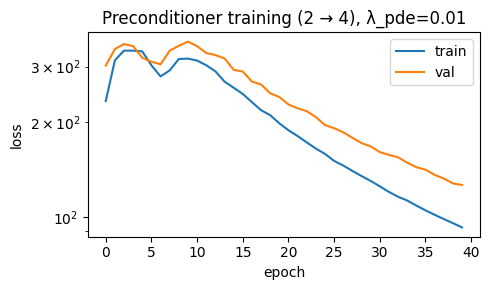

In [22]:
# %%
plt.figure(figsize=(5,3))
plt.semilogy(train_hist["train"], label="train")
plt.semilogy(train_hist["val"],   label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title(f"Preconditioner training (2 → 4), λ_pde={lambda_pde}")
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
# %% [markdown]
# ## Check prediction quality and PDE residual on one sample

# %%
precond_net.eval()
x_val, y_val, b4_val = val_ds[0]  # pick first validation sample

x_in = x_val.unsqueeze(0).to(device)  # (1,C_in,H,W)
with torch.no_grad():
    y_pred = precond_net(x_in)[0].cpu()  # (2,H,W)

# Compute relative L2 error in u
rel_l2_u = torch.norm(y_pred - y_val) / torch.norm(y_val)
print(f"rel L2(u): {rel_l2_u.item():.3e}")

# Compute PDE residual at ω=4
y_pred_np = y_pred.numpy()
u_pred_complex = (y_pred_np[0] + 1j * y_pred_np[1]).reshape(-1)

Au_pred = A_4 @ u_pred_complex
b4_complex = (b4_val[0].numpy() + 1j * b4_val[1].numpy())

residual = Au_pred - b4_complex
rel_pde_res = np.linalg.norm(residual) / np.linalg.norm(b4_complex)
print(f"relative PDE residual ||A_4 u_pred - b_4|| / ||b_4|| = {rel_pde_res:.3e}")


rel L2(u): 7.181e-02
relative PDE residual ||A_4 u_pred - b_4|| / ||b_4|| = 1.104e+00


In [24]:
# %% [markdown]
# ## Sketch: applying the neural preconditioner P⁻¹_θ to a vector v
# 
# Idea:
# - Given a vector v (complex RHS), we solve A_2 u_2 = v (cheap-ish low-frequency solve).
# - Pass u_2 through the neural operator T_θ to get u_4 ≈ A_4⁻¹ v.
# - This P⁻¹_θ(v) can act as a right preconditioner inside GMRES:
#       solve A_4 P⁻¹_θ y = b, u = P⁻¹_θ y.
# 
# Below is a function that implements P⁻¹_θ(v) for a single vector.
# Integrating it as a *true* preconditioner requires modifying gmres_solve to accept M.

# %%
from src.solvers import direct_solve_auto

def apply_nn_preconditioner(v_complex: np.ndarray) -> np.ndarray:
    """
    Approximate A_4^{-1} v using:
    1. Solve A_2 u_2 = v.
    2. Apply neural operator T_θ to u_2 to get u_4 ≈ A_4^{-1} v.
    """
    # 1) Solve A_2 u_2 = v (low-frequency direct solve)
    res_low = direct_solve_auto(
        shape=grid.shape,
        lengths=grid.lengths,
        k=omega_to_k(omega_src),
        rhs=v_complex,
        use_pml=True,
        pml=pml_cfg,
        fd=fd_cfg,
    )
    u2_complex = res_low.solution.reshape(grid.shape)  # (H,W)

    # 2) Build input features for the network: [Re u2, Im u2, x, y, ω_src, ω_tgt]
    H, W = grid.shape
    re = np.real(u2_complex)
    im = np.imag(u2_complex)

    # Coordinates
    xs = np.linspace(0, grid.lengths[0], H)
    ys = np.linspace(0, grid.lengths[1], W)
    X, Y = np.meshgrid(xs, ys, indexing="ij")

    omega_src_ch = omega_src * np.ones_like(X)
    omega_tgt_ch = omega_tgt * np.ones_like(X)

    x_in_np = np.stack([re, im, X, Y, omega_src_ch, omega_tgt_ch], axis=0)  # (6,H,W)

    # Apply same scaling & normalisation as training
    x_in = torch.from_numpy(x_in_np).float().unsqueeze(0).to(device)  # (1,6,H,W)

    precond_net.eval()
    with torch.no_grad():
        y_pred = precond_net(x_in)[0].cpu().numpy()  # (2,H,W)

    u4_complex = (y_pred[0] + 1j * y_pred[1]).reshape(-1)  # flattened
    return u4_complex


rel L2(u_pred, u_tgt) = 7.181e-02


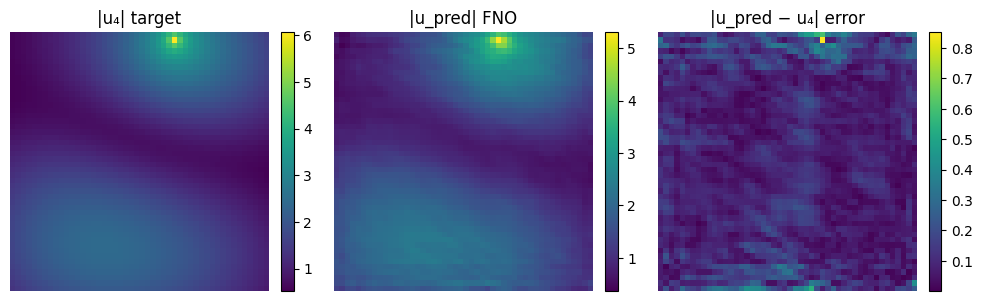

In [26]:
# %% [markdown]
# ## Visualise target, prediction, and error (magnitudes)

# %%
import matplotlib.pyplot as plt
import numpy as np
import torch

precond_net.eval()

# pick a validation sample
idx = 0
x_val, y_val, b4_val = val_ds[idx]        # y_val: (2,H,W)

x_in = x_val.unsqueeze(0).to(device)

with torch.no_grad():
    y_pred = precond_net(x_in)[0].cpu()   # (2,H,W)

# helper: turn 2-channel (Re,Im) into complex and magnitude
def to_complex(field_2ch: torch.Tensor) -> np.ndarray:
    f = field_2ch.numpy()
    return f[0] + 1j * f[1]

u_tgt  = to_complex(y_val)
u_pred = to_complex(y_pred)

mag_tgt  = np.abs(u_tgt)
mag_pred = np.abs(u_pred)
mag_err  = np.abs(u_pred - u_tgt)

# relative L2 error for info
rel_l2 = np.linalg.norm(u_pred - u_tgt) / np.linalg.norm(u_tgt)
print(f"rel L2(u_pred, u_tgt) = {rel_l2:.3e}")

# plot
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.imshow(mag_tgt, origin="lower")
plt.title("|u₄| target")
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mag_pred, origin="lower")
plt.title("|u_pred| FNO")
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(mag_err, origin="lower")
plt.title("|u_pred − u₄| error")
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

plt.tight_layout()
plt.show()


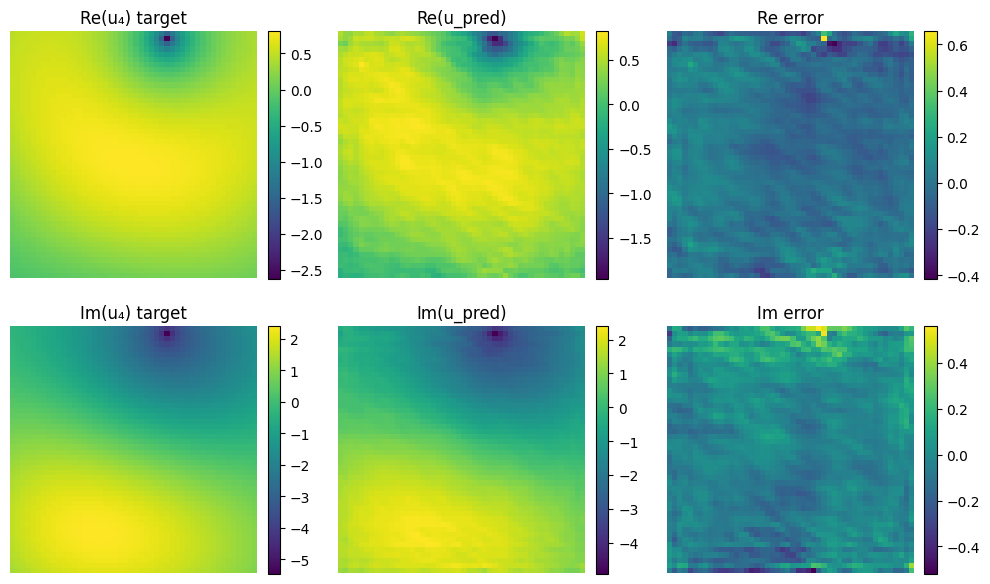

In [27]:
# %% [markdown]
# ## Visualise real and imaginary parts

# %%
re_tgt  = np.real(u_tgt)
im_tgt  = np.imag(u_tgt)
re_pred = np.real(u_pred)
im_pred = np.imag(u_pred)

plt.figure(figsize=(10, 6))

# Real part
plt.subplot(2, 3, 1)
plt.imshow(re_tgt, origin="lower")
plt.title("Re(u₄) target")
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(re_pred, origin="lower")
plt.title("Re(u_pred)")
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

plt.subplot(2, 3, 3)
plt.imshow(re_pred - re_tgt, origin="lower")
plt.title("Re error")
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

# Imag part
plt.subplot(2, 3, 4)
plt.imshow(im_tgt, origin="lower")
plt.title("Im(u₄) target")
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(im_pred, origin="lower")
plt.title("Im(u_pred)")
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

plt.subplot(2, 3, 6)
plt.imshow(im_pred - im_tgt, origin="lower")
plt.title("Im error")
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

plt.tight_layout()
plt.show()


In [28]:
# %% [markdown]
# # Evaluate GMRES iteration counts (baseline vs NN-warmstart)

# %%
import numpy as np
import torch

precond_net.eval()

baseline_iters = []
nn_iters = []

num_tests = 20   # how many validation samples to test
print(f"Evaluating {num_tests} random samples...")

for i in range(num_tests):
    # pick a random validation sample
    idx = np.random.randint(0, len(val_ds))
    x_in, y_true, b4_val = val_ds[idx]

    # move input to device for inference
    x0 = x_in.unsqueeze(0).to(device)

    # === NN prediction (initial guess) ===
    with torch.no_grad():
        y_pred = precond_net(x0)[0].cpu().numpy()   # shape (2,48,48)
    
    # convert prediction to complex field
    u_pred = y_pred[0] + 1j * y_pred[1]

    # true system RHS
    b = b4_val.view(-1).numpy()

    # flatten initial guess for GMRES
    x0_nn = u_pred.reshape(-1)

    # === BASELINE GMRES (initial guess = 0) ===
    its_base, _ = apply_gmres(A_4, b, x0=None)   # your GMRES routine
    baseline_iters.append(its_base)

    # === NN-WARMSTART GMRES ===
    its_nn, _ = apply_gmres(A_4, b, x0=x0_nn)
    nn_iters.append(its_nn)

    print(f"idx={idx:4d} | baseline={its_base:4d} | NN={its_nn:4d}")

# summary
print("\n--- GMRES iteration comparison ---")
print(f"mean baseline iters : {np.mean(baseline_iters):.1f}")
print(f"mean NN-warm iters  : {np.mean(nn_iters):.1f}")
print(f"median baseline     : {np.median(baseline_iters):.1f}")
print(f"median NN-warm      : {np.median(nn_iters):.1f}")


Evaluating 20 random samples...


NameError: name 'apply_gmres' is not defined

In [29]:
# %% [markdown]
# ## Import GMRES solver from src.solvers

# %%
from src.solvers import gmres_solve  # adjust if your version differs

print("GMRES function loaded:", gmres_solve)


GMRES function loaded: <function gmres_solve at 0x0000020538EB6FC0>


In [ ]:
# %% [markdown]
# # Evaluate GMRES iteration counts (baseline vs NN-warmstart)

# %%
import numpy as np
import torch

precond_net.eval()

baseline_iters = []
nn_iters = []

num_tests = 10   # small set for speed
print(f"Evaluating {num_tests} random samples...")

for i in range(num_tests):
    # pick a random validation sample
    idx = np.random.randint(0, len(val_ds))
    x_in, y_true, b4_val = val_ds[idx]

    # move input to device for inference
    x0 = x_in.unsqueeze(0).to(device)

    # === NN prediction ===
    with torch.no_grad():
        y_pred = precond_net(x0)[0].cpu().numpy()   # shape (2,48,48)
    
    # convert prediction to complex
    u_pred = y_pred[0] + 1j * y_pred[1]

    # RHS for system
    b = b4_val.reshape(-1).numpy()

    # flatten NN initial guess
    x0_nn = u_pred.reshape(-1)

    # === BASELINE GMRES (initial guess = 0) ===
    x_base, info_base = gmres_solve(A_4, b, x0=None)
    its_base = info_base.get("iters", -1)
    baseline_iters.append(its_base)

    # === NN-WARMSTART GMRES ===
    x_nn, info_nn = gmres_solve(A_4, b, x0=x0_nn)
    its_nn = info_nn.get("iters", -1)
    nn_iters.append(its_nn)

    print(f"idx={idx:4d} | baseline={its_base:4d} | NN={its_nn:4d}")

# Summary
print("\n--- GMRES iteration comparison ---")
print(f"mean baseline iters : {np.mean(baseline_iters):.1f}")
print(f"mean NN-warm iters  : {np.mean(nn_iters):.1f}")
print(f"median baseline     : {np.median(baseline_iters):.1f}")
print(f"median NN-warm      : {np.median(nn_iters):.1f}")


Evaluating 10 random samples...


ValueError: shapes of A (2304, 2304) and b (4608,) are incompatible

: 